#Signal Detection Framework

## Clone the repository.

In [1]:
import os

%cd /content

# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/shaheer1995/signal_detection'

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'signal_detection'...
remote: Enumerating objects: 132, done.
remote: Total 132 (delta 0), reused 0 (delta 0), pack-reused 132
Receiving objects: 100% (132/132), 52.85 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/signal_detection
Already up to date.


## Install required packages and set up the environment

In [2]:
%cd /content

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!sudo apt install tesseract-ocr
!pip install pytesseract

%tensorflow_version 1.x
import tensorflow as tf

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [3]:
%cd /content/signal_detection/
import wabtec_track
from utils import label_map_util
from utils import ops as utils_ops

/content/signal_detection


In [0]:
test_record_fname = '/content/signal_detection/data/annotations/test.record'
train_record_fname = '/content/signal_detection/data/annotations/train.record'
label_map_pbtxt_fname = '/content/signal_detection/data/annotations/label_map.pbtxt'

In [5]:
def get_num_classes(pbtxt_fname):
    from utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

num_classes = get_num_classes(label_map_pbtxt_fname)

In [0]:
import re
import numpy as np

output_directory = '/content/signal_detection/data/fine_tuned_model'

In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

#Run the Inference Test

In [0]:
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

alphanum = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","Y","X","Y","Z","1,","2","3","4","5","6","7","8","9","0","-",".",",","/"]



def readOCRText(ref_img, target_img):
        # load the reference OCR-A image from disk, convert it to grayscale,
        # and threshold it, such that the digits appear as *white* on a
        # *black* background
        # and invert it, such that the digits appear as *white* on a *black*
        ref = ref_img
        ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
        ref = cv2.threshold(ref, 127, 255, cv2.THRESH_BINARY_INV)[1]

        # find contours in the OCR-A image (i.e,. the outlines of the digits)
        # sort them from left to right, and initialize a dictionary to map
        # digit name to the ROI
        refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
        refCnts = imutils.grab_contours(refCnts)
        refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
        digits = {}

        for (i, c) in enumerate(refCnts):
                # compute the bounding box for the digit, extract it, and resize
                # it to a fixed size
                (x, y, w, h) = cv2.boundingRect(c)
                roi = ref[y:y + h, x:x + w]
                roi = cv2.resize(roi, (57, 88))
                # update the digits dictionary, mapping the digit name to the ROI
                digits[i] = roi

        sample = target_img
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
        sample = cv2.threshold(sample, 127, 255, cv2.THRESH_BINARY_INV)[1]

        # detect the contours of each individual digit in the group,
        # then sort the digit contours from left to right
        digitCnts = cv2.findContours(sample.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
        digitCnts = imutils.grab_contours(digitCnts)
        digitCnts = contours.sort_contours(digitCnts,
                method="left-to-right")[0]

        groupOutput = []

        # loop over the digit contours
        for c in digitCnts:
                # compute the bounding box of the individual digit, extract
                # the digit, and resize it to have the same fixed size as
                # the reference OCR-A images
                (x, y, w, h) = cv2.boundingRect(c)
                #print (str(x) +","+str(y)+","+str(w)+","+str(h))
                roi = sample[y:y + h, x:x + w]
                roi = cv2.resize(roi, (57, 88))
                #cv2.imshow("Image", roi)
                #mcv2.waitKey(0)
                # initialize a list of template matching scores
                scores = []

                # loop over the reference digit name and digit ROI
                for (digit, digitROI) in digits.items():
                        # apply correlation-based template matching, take the
                        # score, and update the scores list
                        result = cv2.matchTemplate(roi, digitROI,
                                cv2.TM_CCOEFF)
                        #print(result)

                        (_, score, _, _) = cv2.minMaxLoc(result)
                        scores.append(score)
                        #print(score)
                if np.max(scores)>10000000:
                        groupOutput.append(str(alphanum[np.argmax(scores)]))
        #                 print(str(np.argmax(scores)))
        # print("---------------------------------------------------------------------")
        return groupOutput


In [16]:
   ref_image = cv2.imread('/content/signal_detection/reference_image.png')
   print(ref_image)


[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


['/content/signal_detection/test/Caltrain_01-08-20_Page_4.jpg']
     type   id              milepost
0  switch   /3        MMPP0066443704
1  switch  K11               MP07098
2  switch   9A               MP08926
3  switch  X7A               MP07884
4  switch   98               MP08072
5  switch  11A            M.P.0.7672
6  switch   5A       MMPP00.67080798
7  switch   5A  MMIP1P001.66818271C8


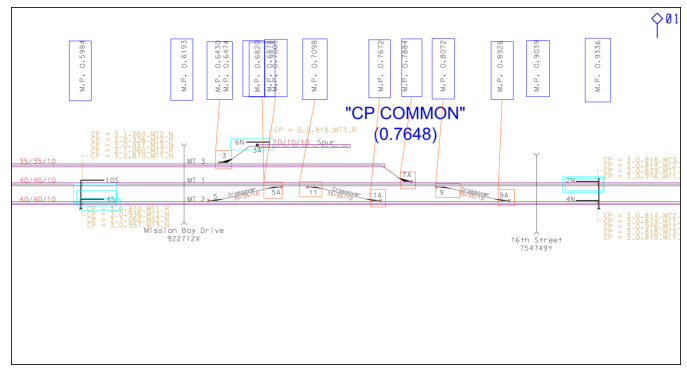

In [23]:
import os
import glob
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import pytesseract
from pytesseract import Output
import shutil
import cv2
import zipfile
import pandas as pd
import wabtec_track

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import files
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

%matplotlib inline

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join("/content/signal_detection", "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

'''
  To Visualize Initiate the following array
  Array Order ["Switch","Track","Left signal","Right Signal", "all"]
  Ex: If you want bounding boxes only on switches and Tracks
      array should be [1,1,0,0]
'''
visualize = [1,1,1,1,0]

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

s_id = []
milepost = []
s_type = []

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# preprocessing
def switch_preprocess(crop_image):
  kernel = np.ones((3,3),np.uint8)
  gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
  (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  inverse = cv2.bitwise_not(gray)
  closed = cv2.morphologyEx(inverse, cv2.MORPH_CLOSE, kernel)
  #dilation = cv2.dilate(inverse,kernel,iterations = 1)
  dil_inv = cv2.bitwise_not(closed)
  opened = cv2.morphologyEx(dil_inv, cv2.MORPH_OPEN, kernel)
  #opened = cv2.dilate(thresh, kernel, iterations = 1)
  custom_config = r'--oem 3 --psm 6'
  img = Image.fromarray(opened)
  sid = pytesseract.image_to_string(img, config=custom_config)
  return sid

def milestone_preprocess(crop_image):
  gray = cv2.cvtColor(r_img,cv2.COLOR_RGB2GRAY)
  kernel = np.ones((3,3),np.uint8)
  im = np.array(gray * 255, dtype = np.uint8)
  (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  #opened = cv2.dilate(thresh, kernel, iterations = 1)
  custom_config = r'--oem 3 --psm 6'
  img = Image.fromarray(gray)
  milestone_id = pytesseract.image_to_string(img, config=custom_config)
  #print(pytesseract.image_to_string(img, config=custom_config))
  return milestone_id

#Draw Bounding boxes
def drawBoundingBoxes(xmin,ymin,xmax,ymax,r,g,b,t):
  x1,y1,x2,y2 = np.int64(xmin * im_width), np.int64(ymin * im_height), np.int64(xmax * im_width), np.int64(ymax * im_height)
  cv2.rectangle(image_np, (x1, y1), (x2, y2), (r, g, b), t)

#Rn Inference on single image
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    #Image to crop labels
    image_to_crop = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.4

    #Obtaining detection boxes, classes and detection scores
    boxes = np.squeeze(output_dict['detection_boxes'])
    scores = np.squeeze(output_dict['detection_scores'])
    classes = np.squeeze(output_dict['detection_classes'])
    #set a min thresh score
    ########
    min_score_thresh = 0.25
    ########
    #Filtering the bounding boxes
    bboxes = boxes[scores > min_score_thresh]
    d_classes = classes[scores > min_score_thresh]
    switch_boxes = bboxes[d_classes == 4]
    milepost_boxes = bboxes[d_classes == 2]
    left_signal_boxes = bboxes[d_classes == 1]
    right_signal_boxes = bboxes[d_classes == 3]

    #get image size
    im_width, im_height = image.size

    final_box = []
    for box in bboxes:
        ymin, xmin, ymax, xmax = box
        final_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
    #print(final_box)

    if(visualize[0] == 1 or visualize[4] == 1):
      sw_box = []
      for box in switch_boxes:
          ymin, xmin, ymax, xmax = box
          sw_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
          drawBoundingBoxes(xmin,ymin,xmax,ymax,256,100,25,2)

    if(visualize[2] == 1 or visualize[4] == 1):
      ls_box = []
      for box in left_signal_boxes:
          ymin, xmin, ymax, xmax = box
          ls_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
          drawBoundingBoxes(xmin,ymin,xmax,ymax,0,255,255,2)

    if(visualize[2] == 1 or visualize[4] == 1):
      rs_box = []
      for box in right_signal_boxes:
          ymin, xmin, ymax, xmax = box
          rs_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
          drawBoundingBoxes(xmin,ymin,xmax,ymax,0,255,255,2)

    m_box = []
    for box in milepost_boxes:
        ymin, xmin, ymax, xmax = box
        m_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
        drawBoundingBoxes(xmin,ymin,xmax,ymax,0,0,256,2)

    
    #switch
    if(visualize[0] == 1):
      for box in sw_box:
        ymin, xmin, ymax, xmax = box
        y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
        crop_img = image_to_crop[h-10:w+10,y-10:x+10]
        # plt.figure(figsize=(1,2))
        # plt.imshow(crop_img) 
        for b in m_box:
            ymin, xmin, ymax, xmax = b
            a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
            val = (y+x)/2
            mid_milepost_x = np.int64((a+c)/2)
            mid_milepost_y = np.int64((b+d)/2)
            if(a<val and val<c ):
              if(h>b):
                cv2.line(image_np, (y,h), (mid_milepost_x,d), (256,100,25), 2)
              else:
                cv2.line(image_np, (y,w), (mid_milepost_x,b), (256,100,25), 2)
              crop_ml = image_to_crop[b-5:d+5,a+5:c-5]
              r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
              # if '\n' in milestone_preprocess(r_img):
              #   milepost.append(milestone_preprocess(r_img).split('\ ')[4:14])
              # else:
              #   milepost.append(milestone_preprocess(r_img)[5:14])
              milepost_str = ' '.join(map(str, readOCRText(ref_image,r_img)))
              switch_str = ' '.join(map(str, readOCRText(ref_image,crop_img)))
              milepost_withoutcomma = milepost_str.replace(',','')
              switch_withoutcomma = switch_str.replace(',','')
              milepost.append(milepost_withoutcomma.replace(' ',''))
              s_id.append(switch_withoutcomma.replace(' ',''))
              s_type.append("switch")
              #plt.imshow(r_img,cmap='gray') 
    
    if(visualize[1]==1 or visualize[4] == 1): 
      t_img = cv2.imwrite('color_img.jpg', image_np)
      wtt = wabtec_track.WabTecTrack(file_name='color_img.jpg')
      tracks = wtt.get_lines()  
      for track in tracks:
        (x1,y1) = track.point_one()
        (x2,y2) = track.point_two()
        cv2.rectangle(image_np, (x1-10, y1-10), (x2+10, y2+10), (128, 0, 128), 2)
       
    #print(category_index)
    #print(d_classes)
    #print(m_box)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.xticks([])
    plt.yticks([])
    

dict = {'type': s_type, 'id':s_id, 'milepost':milepost}
df = pd.DataFrame(dict)
print(df)
# df.to_csv (r'extracted_data.csv', index = False, header=True)
# files.download('extracted_data.csv')